In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from pathlib import Path

In [25]:
# root_path = "/mnt/storage/ji/brain_mri_valdo_mayo/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s_cmb_slice_only_train"
root_path = "/mnt/storage/ji/brain_mri_valdo_mayo/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s"
task = "train_mean_pixel"

### Dataset Visualization

In [26]:
img_num = "207"
slice_num = "064"

### Mask

In [27]:
# mask_path = f"{root_path}/masks/{task}/sub-{img_num}_slice_{slice_num}.png"
# mask = Image.open(mask_path)
# mask = np.array(mask)
# print(np.sum(mask==255))
# plt.imshow(mask, cmap='gray')

In [28]:
# with open("raw_output.txt", "w") as f:
#     for row in mask:
#         f.write(" | ".join(f"{num:6.2f}" for num in row) + "\n")


In [29]:
# np.set_printoptions(threshold=np.inf)
# print(mask)

### Ground Truth Box

In [30]:
def extract_patch(channel, center_x, center_y, patch_size):
    """
    Extract a fixed-size patch centered on the given coordinates
    """
    height, width = channel.shape
    half_size = patch_size // 2
    
    # Calculate patch boundaries
    x_min = int(center_x - half_size)
    y_min = int(center_y - half_size)
    x_max = int(center_x + half_size)
    y_max = int(center_y + half_size)
    
    # Handle edge cases
    if x_min < 0:
        x_max -= x_min  # Shift patch right
        x_min = 0
    if y_min < 0:
        y_max -= y_min  # Shift patch down
        y_min = 0
    if x_max > width:
        x_min -= (x_max - width)  # Shift patch left
        x_max = width
    if y_max > height:
        y_min -= (y_max - height)  # Shift patch up
        y_max = height
    
    return channel[y_min:y_max, x_min:x_max]

def plot_yolo_boxes_with_channel_patches(image_path, bboxes):
    """
    Plot original channels and their 16x16 patches without overlap
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    height, width = image.shape[:2]
    n_boxes = len(bboxes)
    
    if n_boxes == 0:
        print("No bounding boxes found in the image.")
        return
        
    # Create figure with original image row plus one row per bbox
    fig = plt.figure(figsize=(15, 4 * (n_boxes + 1)))

    # Create GridSpec with n_boxes + 1 rows (1 for original images, rest for patches)
    gs = plt.GridSpec(n_boxes + 1, 3, figure=fig, hspace=0.4)

    # Channel names
    channel_names = ['T1', 'T2', 'T2S']

    # Plot each channel
    for channel_idx, channel_name in enumerate(channel_names):
        # Extract channel
        channel = image[:, :, channel_idx]

        # Plot full image in top row
        ax = fig.add_subplot(gs[0, channel_idx])
        # im = ax.imshow(channel, cmap='gray', vmin=0, vmax=255)
        im = ax.imshow(channel, cmap='gray')
        ax.set_title(f'{channel_name}')
        plt.colorbar(im, ax=ax, label='Intensity')
        
        # Draw all bounding boxes on original image
        for bbox in bboxes:
            class_id, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            patch_size = gt_width * width
            
            # Draw fixed-size box
            half_size = patch_size // 2
            x_min = center_x - half_size
            y_min = center_y - half_size
            if class_id == 0.0:
                rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.3, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            elif class_id == 1.0:
                rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.3, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)
            
        
        # Plot patches
        for box_idx, bbox in enumerate(bboxes):
            _, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            # Extract patch
            patch_size = gt_width * width
            patch = extract_patch(channel, center_x, center_y, patch_size)
            # Create subplot for patch in its own row
            ax_patch = fig.add_subplot(gs[box_idx + 1, channel_idx])
            # im_patch = ax_patch.imshow(patch, cmap='gray', vmin=0, vmax=255)
            im_patch = ax_patch.imshow(patch, cmap='gray')
            ax_patch.set_title(f'{channel_name} Patch {box_idx + 1}')
            plt.colorbar(im_patch, ax=ax_patch, label='Intensity')
            ax_patch.axis('on')
    
    plt.suptitle('Ground Truth', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

def visualize_image_channels_and_patches(root_path, img_num, slice_num):
    """
    Visualize MRI channels and their patches with fixed-size boxes
    """
    label_path = f"{root_path}/labels/{task}/sub-{img_num}_slice_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")

    plot_original_image(image_path)
    
    try:
        with open(label_path, 'r') as txt_file:
            bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        
        plot_yolo_boxes_with_channel_patches(image_path, bboxes)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")
            
def plot_original_image(img_path):    
    img = Image.open(img_path)
    img = np.array(img)
    
    print(img.shape)
    plt.figure(figsize=(10, 10))

    plt.imshow(img[:,:], cmap='gray')
    plt.title('T1 Original Image')

(512, 512)
An error occurred: [Errno 2] No such file or directory: '/mnt/storage/ji/brain_mri_valdo_mayo/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s/labels/train_mean_pixel/sub-207_slice_064.txt'
Image format: PNG
Image size: (512, 512)
Image mode: L


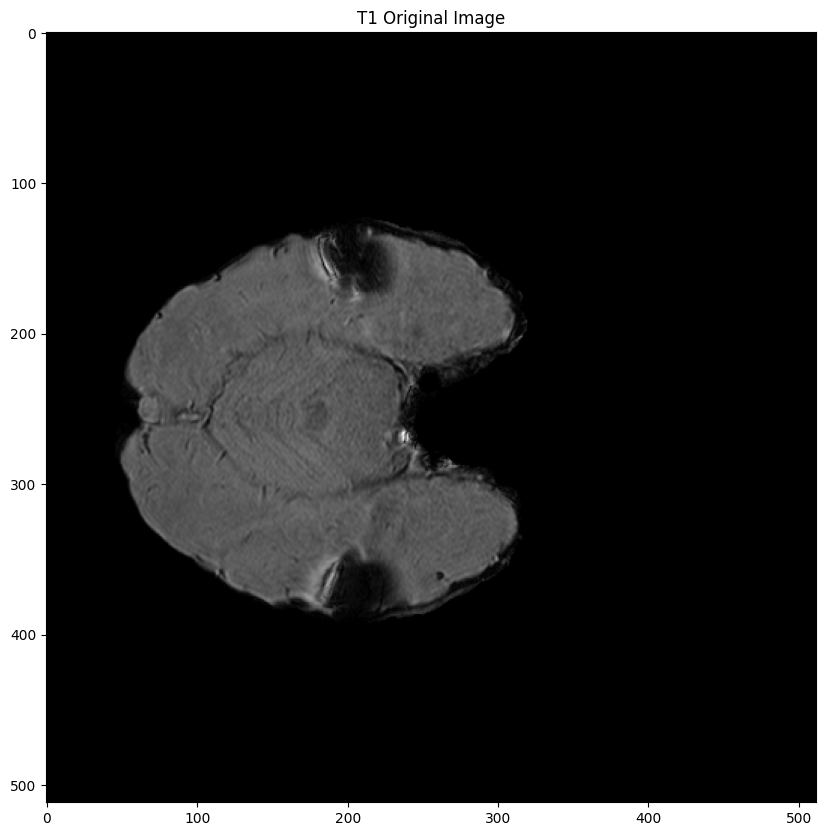

In [31]:
visualize_image_channels_and_patches(root_path, img_num, slice_num)

In [32]:
def find_nonempty_text_files(directory):
    nonempty_files = []
    dir_path = Path(directory)
    for txt_file in dir_path.glob("*.txt"):
        if txt_file.stat().st_size > 0:
            with open(txt_file, 'r') as f:
                content = f.read().strip()
                if content:  # Check if there's actual content after stripping whitespace
                    nonempty_files.append(txt_file.name)  
    return sorted(nonempty_files)  # Sort alphabetically

directory = f"{root_path}/labels/{task}"  # Replace with your folder path
nonempty_files = find_nonempty_text_files(directory)

count = 0
print(f"Found {len(nonempty_files)} non-empty text files:")
for filename in nonempty_files:
    count += 1
    print(f"- {filename}")
print(count)

Found 0 non-empty text files:
0
